In [ ]:
# https://documentation.dataspace.copernicus.eu/notebook-samples/openeo/NDVI_Timeseries.html

In [80]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal
import numpy as np
import geopandas as gpd
import openeo
from shapely.geometry import shape
from shapely.geometry import Point

In [81]:
connection = openeo.connect(url="openeo.dataspace.copernicus.eu")
connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

In [82]:
def read_json(filename: str) -> dict:
    with open(filename,encoding="utf-8") as input:
        field = json.load(input)
    return field

fields = read_json(r"C:\GIS_Course\EGM722\Project\Data\test_landfill.geojson")


In [84]:
s2cube = connection.load_collection(
    "SENTINEL_5P_L2",
    temporal_extent=["2021-08-01", "2021-10-31"],
    bands=["CH4"],
)

In [36]:
#swir1 = s2cube.band("B11")  # SWIR band 1
#swir2 = s2cube.band("B12")  # SWIR band 2
#swir_sum = swir1 + swir2  # Add SWIR bands together
#avg_swir = swir_sum / 2  # Divide the sum by 2

In [85]:
timeseries = s2cube.aggregate_spatial(geometries=fields, reducer="mean")


In [97]:
job = timeseries.execute_batch(out_format="CSV", title="SWIR timeseries")

0:00:00 Job 'j-2404125d6c764a8393431206da10902c': send 'start'
0:00:14 Job 'j-2404125d6c764a8393431206da10902c': created (progress N/A)
0:00:20 Job 'j-2404125d6c764a8393431206da10902c': created (progress N/A)
0:00:26 Job 'j-2404125d6c764a8393431206da10902c': created (progress N/A)
0:00:34 Job 'j-2404125d6c764a8393431206da10902c': created (progress N/A)
0:00:45 Job 'j-2404125d6c764a8393431206da10902c': running (progress N/A)
0:00:57 Job 'j-2404125d6c764a8393431206da10902c': running (progress N/A)
0:01:13 Job 'j-2404125d6c764a8393431206da10902c': running (progress N/A)
0:01:33 Job 'j-2404125d6c764a8393431206da10902c': running (progress N/A)
0:01:57 Job 'j-2404125d6c764a8393431206da10902c': running (progress N/A)
0:02:27 Job 'j-2404125d6c764a8393431206da10902c': running (progress N/A)
0:03:05 Job 'j-2404125d6c764a8393431206da10902c': finished (progress N/A)


In [98]:
job.get_results().download_file("swir-results/timeseries-basic.csv")

pd.read_csv("swir-results/timeseries-basic.csv", index_col=0)


,feature_index,avg(band_0)
date,,
2021-08-03T00:00:00.000Z,0,NaN
2021-08-01T00:00:00.000Z,0,NaN
2021-08-02T00:00:00.000Z,0,NaN
2021-08-23T00:00:00.000Z,0,NaN
2021-08-24T00:00:00.000Z,0,NaN
...,...,...
2021-10-09T00:00:00.000Z,0,NaN
2021-10-08T00:00:00.000Z,0,1899.230713
2021-10-29T00:00:00.000Z,0,NaN


In [108]:
def plot_timeseries(filename, figsize=(15, 3)):
    df = pd.read_csv(filename, index_col=0)
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()

    fig, ax = plt.subplots(figsize=figsize, dpi=90)
    df.groupby("feature_index")["avg(band_0)"].plot(marker="o", ax=ax)
    ax.set_title(filename.split("/")[-1])
    ax.set_ylabel("CH4")
    ax.set_ylim(0, 5000)
    ax.legend(title="parcel id", loc='upper left', bbox_to_anchor=(1.02, 1), ncol=2)
    ax.xaxis.set_major_locator(plt.MaxNLocator(20))
    ax.grid(True)


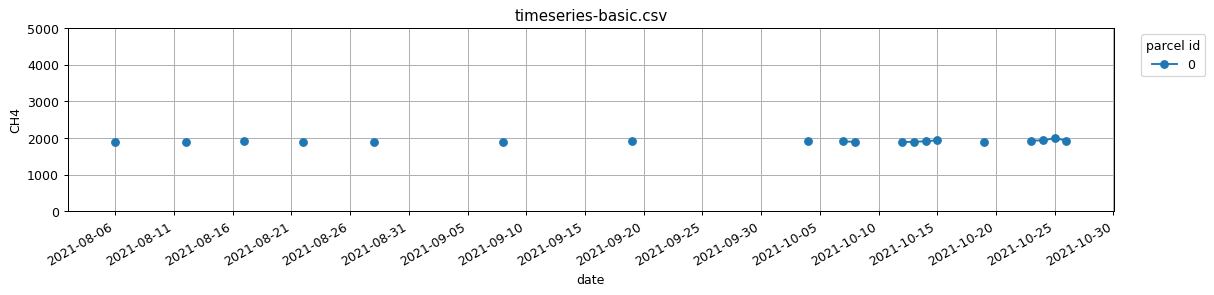

In [109]:
plot_timeseries("swir-results/timeseries-basic.csv")

In [ ]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2020-06-01", "2020-10-01"],
    bands=["B04", "B08", "SCL"],
)
red = s2cube.band("B04")
nir = s2cube.band("B08")
ndvi = (nir - red) / (nir + red)

In [ ]:
scl = s2cube.band("SCL")
mask = ~((scl == 4) | (scl == 5))

In [ ]:
# 2D gaussian kernel
g = scipy.signal.windows.gaussian(11, std=1.6)
kernel = np.outer(g, g)
kernel = kernel / kernel.sum()

# Morphological dilation of mask: convolution + threshold
mask = mask.apply_kernel(kernel)
mask = mask > 0.1

In [ ]:
ndvi_masked = ndvi.mask(mask)
timeseries_masked = ndvi_masked.aggregate_spatial(geometries=fields, reducer="mean")

In [ ]:
job = timeseries_masked.execute_batch(out_format="CSV", title="Maked NDVI timeseries")

In [ ]:
job.get_results().download_file("ndvi-results/timeseries-masked.csv")

In [ ]:
plot_timeseries("ndvi-results/timeseries-masked.csv")

In [ ]:
udf = openeo.UDF(
    """
from scipy.signal import savgol_filter
from openeo.udf import XarrayDataCube

def apply_datacube(cube: XarrayDataCube, context: dict) -> XarrayDataCube:
    array = cube.get_array()
    filled = array.interpolate_na(dim='t')
    smoothed_array = savgol_filter(filled.values, 5, 2, axis=0)
    return DataCube(xarray.DataArray(smoothed_array, dims=array. dims,coords=array.coords))
"""
)

In [ ]:
ndvi_smoothed = ndvi_masked.apply_dimension(code=udf, dimension="t")

In [ ]:
timeseries_smoothed = ndvi_smoothed.aggregate_spatial(geometries=fields, reducer="mean")


In [ ]:
job = timeseries_smoothed.execute_batch(
    out_format="CSV", title="Smoothed NDVI timeseries"
)

In [ ]:
job.get_results().download_file("ndvi-results/timeseries-smoothed.csv")


In [ ]:
plot_timeseries("ndvi-results/timeseries-smoothed.csv")
